## Stark Broadening Asymmetries From SPY

[The SPY survey](https://ui.adsabs.harvard.edu/abs/2020A%26A...638A.131N/abstract) has a ton of high-res WD spectra. I'm gonna see how much Stark broadening affects their absorption lines.

In [10]:
import glob
import os
import numpy as np

from astropy.io import ascii
from astropy.table import Table, join
import matplotlib.pyplot as plt
plt.style.use('../../proj/core-composition/notebooks/stefan.mplstyle')

In [11]:
from stark import catalog as ct
from stark import measure as meas

# read in the object file from CDS
cat = ct.fetch_objfile()

## Uncomment to run only the SDSS WDs
#sdss_wds = Table.read('./data/raw/25SDSS_inSPY.csv')
#sdss_wds.remove_columns(['ra', 'dec'])
#cat = join(cat, sdss_wds, keys_left='Name', keys_right='Name_2', join_type='inner')

The raw spectra downloaded directly off of the CDS archive lives at `./data/raw/sp/`. These spectra are in air wavelengths, and their radial velocities are reported in the heliocentric frame. That means that we need to convert to vacuum wavelengths and determine the heliocentric correction. Doing this for all the files takes a while. I'm going to pre-compute it soon, but I haven't gotten there yet. 

The `spec` variable is a dictionary whose keys are filenames and whose data are the associated wavelengths. The `obj` variable is a table containing all the information from the CDS archive, as well as the heliocentric correction. 

In [12]:
#spec, obj = ct.read_spectrum(cat, './data/raw/sp', download_files=True)

In [4]:
import pickle

with open('./data/raw/spectra.pkl', 'rb') as f:
    spec = pickle.load(f)

obj = Table.read('./data/raw/object_params.csv')

This is the line that does the actual analysis. The parameter `from_cache=True` means that you can stop the calculation and start it at another time using the data contained in the file it's pointing to. If you want to just look at the results, you can comment out the `analyze_spectra()` line and uncomment the json read line.

In [ ]:
import json

lines = ['a','b','g','d']
measured = meas.analyze_spectra(spec, './data/processed/all_wds_Habgd.json', lines = lines, from_cache=True)

#with open('./data/processed/all_wds_Habgd.json') as json_file:
#    measured = json.load(json_file)

This cell converts the json file into a pandas dataframe, then calculates a mask based on the parameters specified in the `apply_rules()` function. After that, it fills in any masked values with `NaN` so that they'll be ignored.

In [6]:
df = ct.tabularize(measured)
df_with_mask = ct.apply_rules(df, sigma = 3 , rv_over_err = 3, chisqr = 10)
df_masked = ct.apply_mask(df_with_mask, rows = ['rvs', 'e_rvs', 'differentials', 'significance', 
                                             'redchisqr', 'teff', 'e_teff', 'logg', 'e_logg'])

In [7]:
temp_bin_edges = [0, 13000, 16000]
df_binned, range_func, center_func = ct.bin_temperatures(df_masked, temp_bin_edges)

In [8]:
for edge in np.unique(df.teff_bin):
    print(f"{edge} | {range_func(edge)} | # objects = {(df['teff_bin'] == edge).sum()}")

1 | (0, 13000) | # objects = 14
2 | (13000, 16000) | # objects = 3
3 | (16000, inf) | # objects = 8


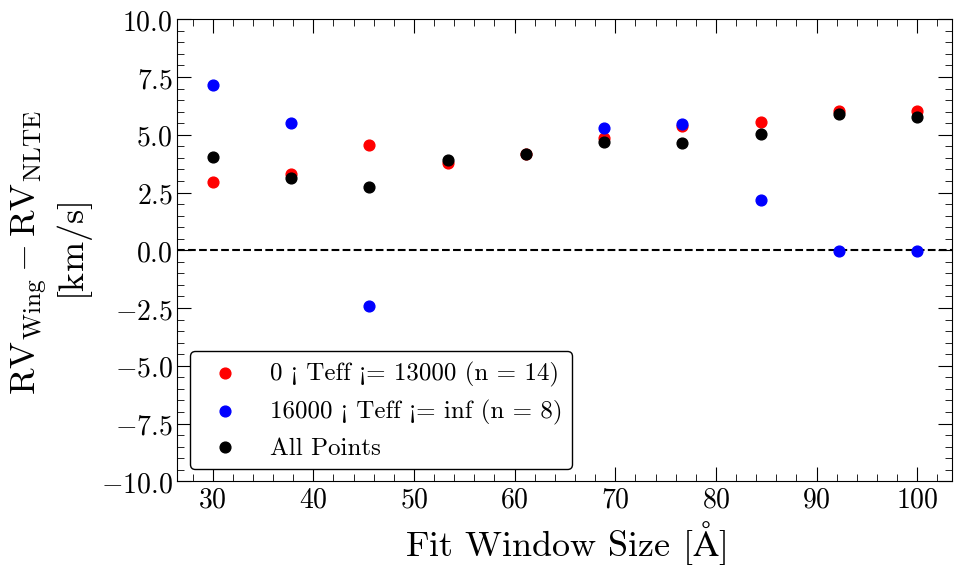

In [9]:
def plot_ensemble(df):
    fig, ax = plt.subplots(nrows = 1, figsize=(10,6))

    colors = {1 : 'red', 3 : 'blue'}
    for edge in np.unique(df.teff_bin)[::2]:
        subset = df.query(f"teff_bin == {edge}")
        diffs = np.array(subset.differentials.tolist(), dtype=float)
        wl = np.array(subset.windows.tolist())[0,1:]

        avg_rows = (np.count_nonzero(~np.isnan(diffs)) // 10)
        mean_diff = np.nanmean(diffs[:,1:], axis=0)
        median_diff = np.nanmedian(diffs[:,1:], axis=0)
        std_diff = np.nanstd(diffs[:,1:], axis=0)

        scatter = {'s' : 40}
        low, hi = range_func(edge)
        ax.scatter(wl, median_diff, label = f'{low} < Teff <= {hi} (n = {len(subset)})', color = colors[edge], s = 60, zorder=10)

    diffs = np.array(df.differentials.tolist(), dtype=float)
    wl = np.array(df.windows.tolist())[0,1:]

    avg_rows = (np.count_nonzero(~np.isnan(diffs)) // 10)
    mean_diff = np.nanmean(diffs[:,1:], axis=0)
    median_diff = np.nanmedian(diffs[:,1:], axis=0)
    std_diff = np.nanstd(diffs[:,1:], axis=0)

    scatter = {'s' : 40}
    low, hi = range_func(edge)
    ax.scatter(wl, median_diff, label = f'All Points', color = 'k', s = 60, zorder=10)

    xmin, xmax = ax.get_xlim()
    #ax.fill_between([xmin,xmax], -ref_e_rv, ref_e_rv, color='green', alpha=0.5, zorder=0)
    ax.set_xlim(xmin, xmax)
    ax.axhline(y = 0, c = 'k', ls = '--')

    hfont = {'fontname':'Helvetica'}
    ax.set_ylim(-10,10)   
    ax.set_xlabel(r'Fit Window Size [$\AA$]')
    ax.set_ylabel('$RV_{Wing} - RV_{NLTE}$ \n$[km /s]$')
    ax.legend()

plot_ensemble(df_masked)